# Load TS

In [1]:
import numpy as np
import os

def loadnpy(filename):
    return np.load(filename)


dir_path = 'dataset/time_series/'
# dir_path = 'dataset/cleaned_time_series/'
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = loadnpy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)

# Offset translation and Amplitude scaling

In [2]:
for i in range(len(X)):
    X[i] = X[i] - X[i].mean() #Offset translation
for i in range(len(X)):
    X[i] = (X[i] - X[i].mean()) / X[i].std() #Amplitue scaling

# Trend removal

In [3]:
N = 5
slope_threshold = 0.0017
trending_series_indices = []

def estimate_slope(y_values, x_values):
        slope = np.polyfit(x_values, y_values, 1)[0]
        return slope

def calculate_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


for i in range(len(X)):
    moving_avg = calculate_moving_average(X[i,-1].T, N)

    x_values = np.arange(N-1, N-1 + len(moving_avg))

    slope = estimate_slope(moving_avg, x_values)
    if slope > slope_threshold:
        trending_series_indices.append(i)

print(f"Indices of trending time series: {trending_series_indices}")
print(f"Number of trending time series: {len(trending_series_indices)}")

Indices of trending time series: [423, 562, 826, 1072, 1199, 1801, 1857, 2170, 2203, 2562, 2849, 2931, 3558, 4041, 4231, 4579, 5001, 5516, 5646, 5771, 5898, 6099, 6164, 6401, 6418, 7503, 8553, 8974, 8981, 9187, 9488, 9509, 9582]
Number of trending time series: 33


plot time series with trend detected

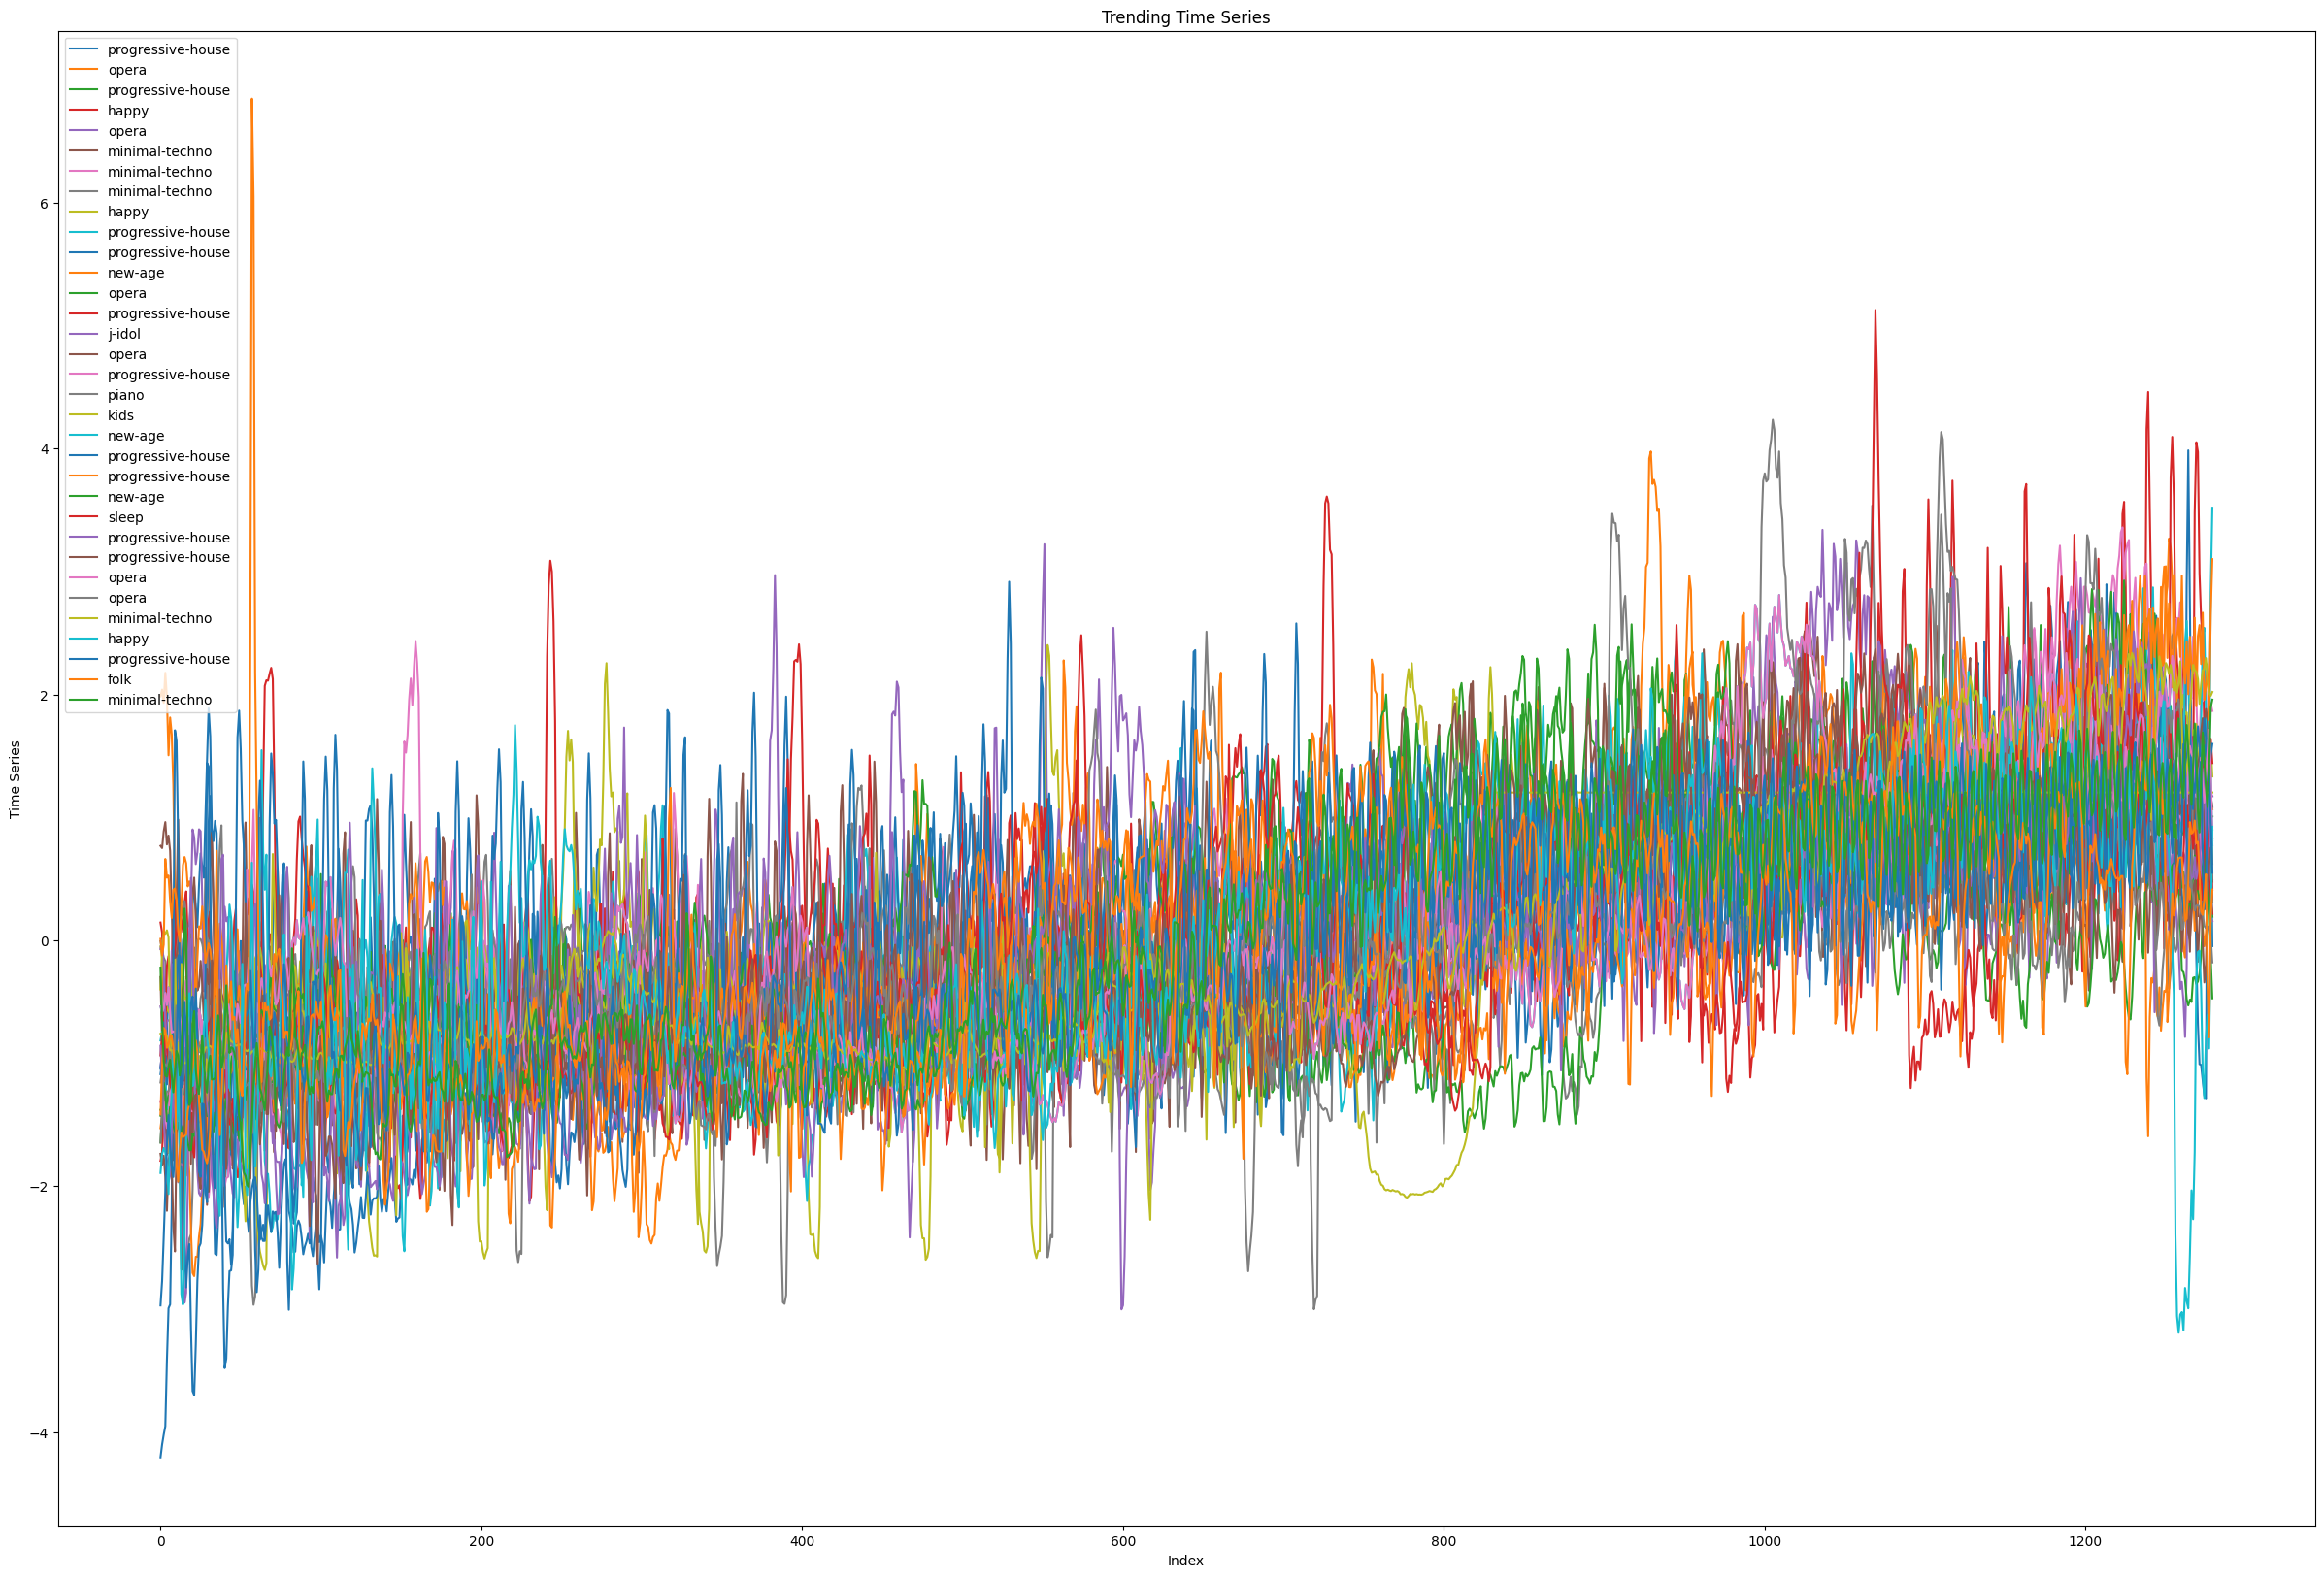

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))
for index in trending_series_indices:
    plt.plot(X[index][0])
    
plt.xlabel('Index')
plt.ylabel('Time Series')
plt.title('Trending Time Series')
plt.legend(y[trending_series_indices])
plt.show()

Detrend

In [5]:
from sktime.transformations.series.detrend import Detrender

# Creazione dell'istanza del detrender
detrender = Detrender()

# Adattamento del detrender ai dati
detrender.fit(X[trending_series_indices])

# Trasformazione dei dati utilizzando il detrender adattato
X[trending_series_indices] = detrender.transform(X[trending_series_indices])

Plot detrended time series

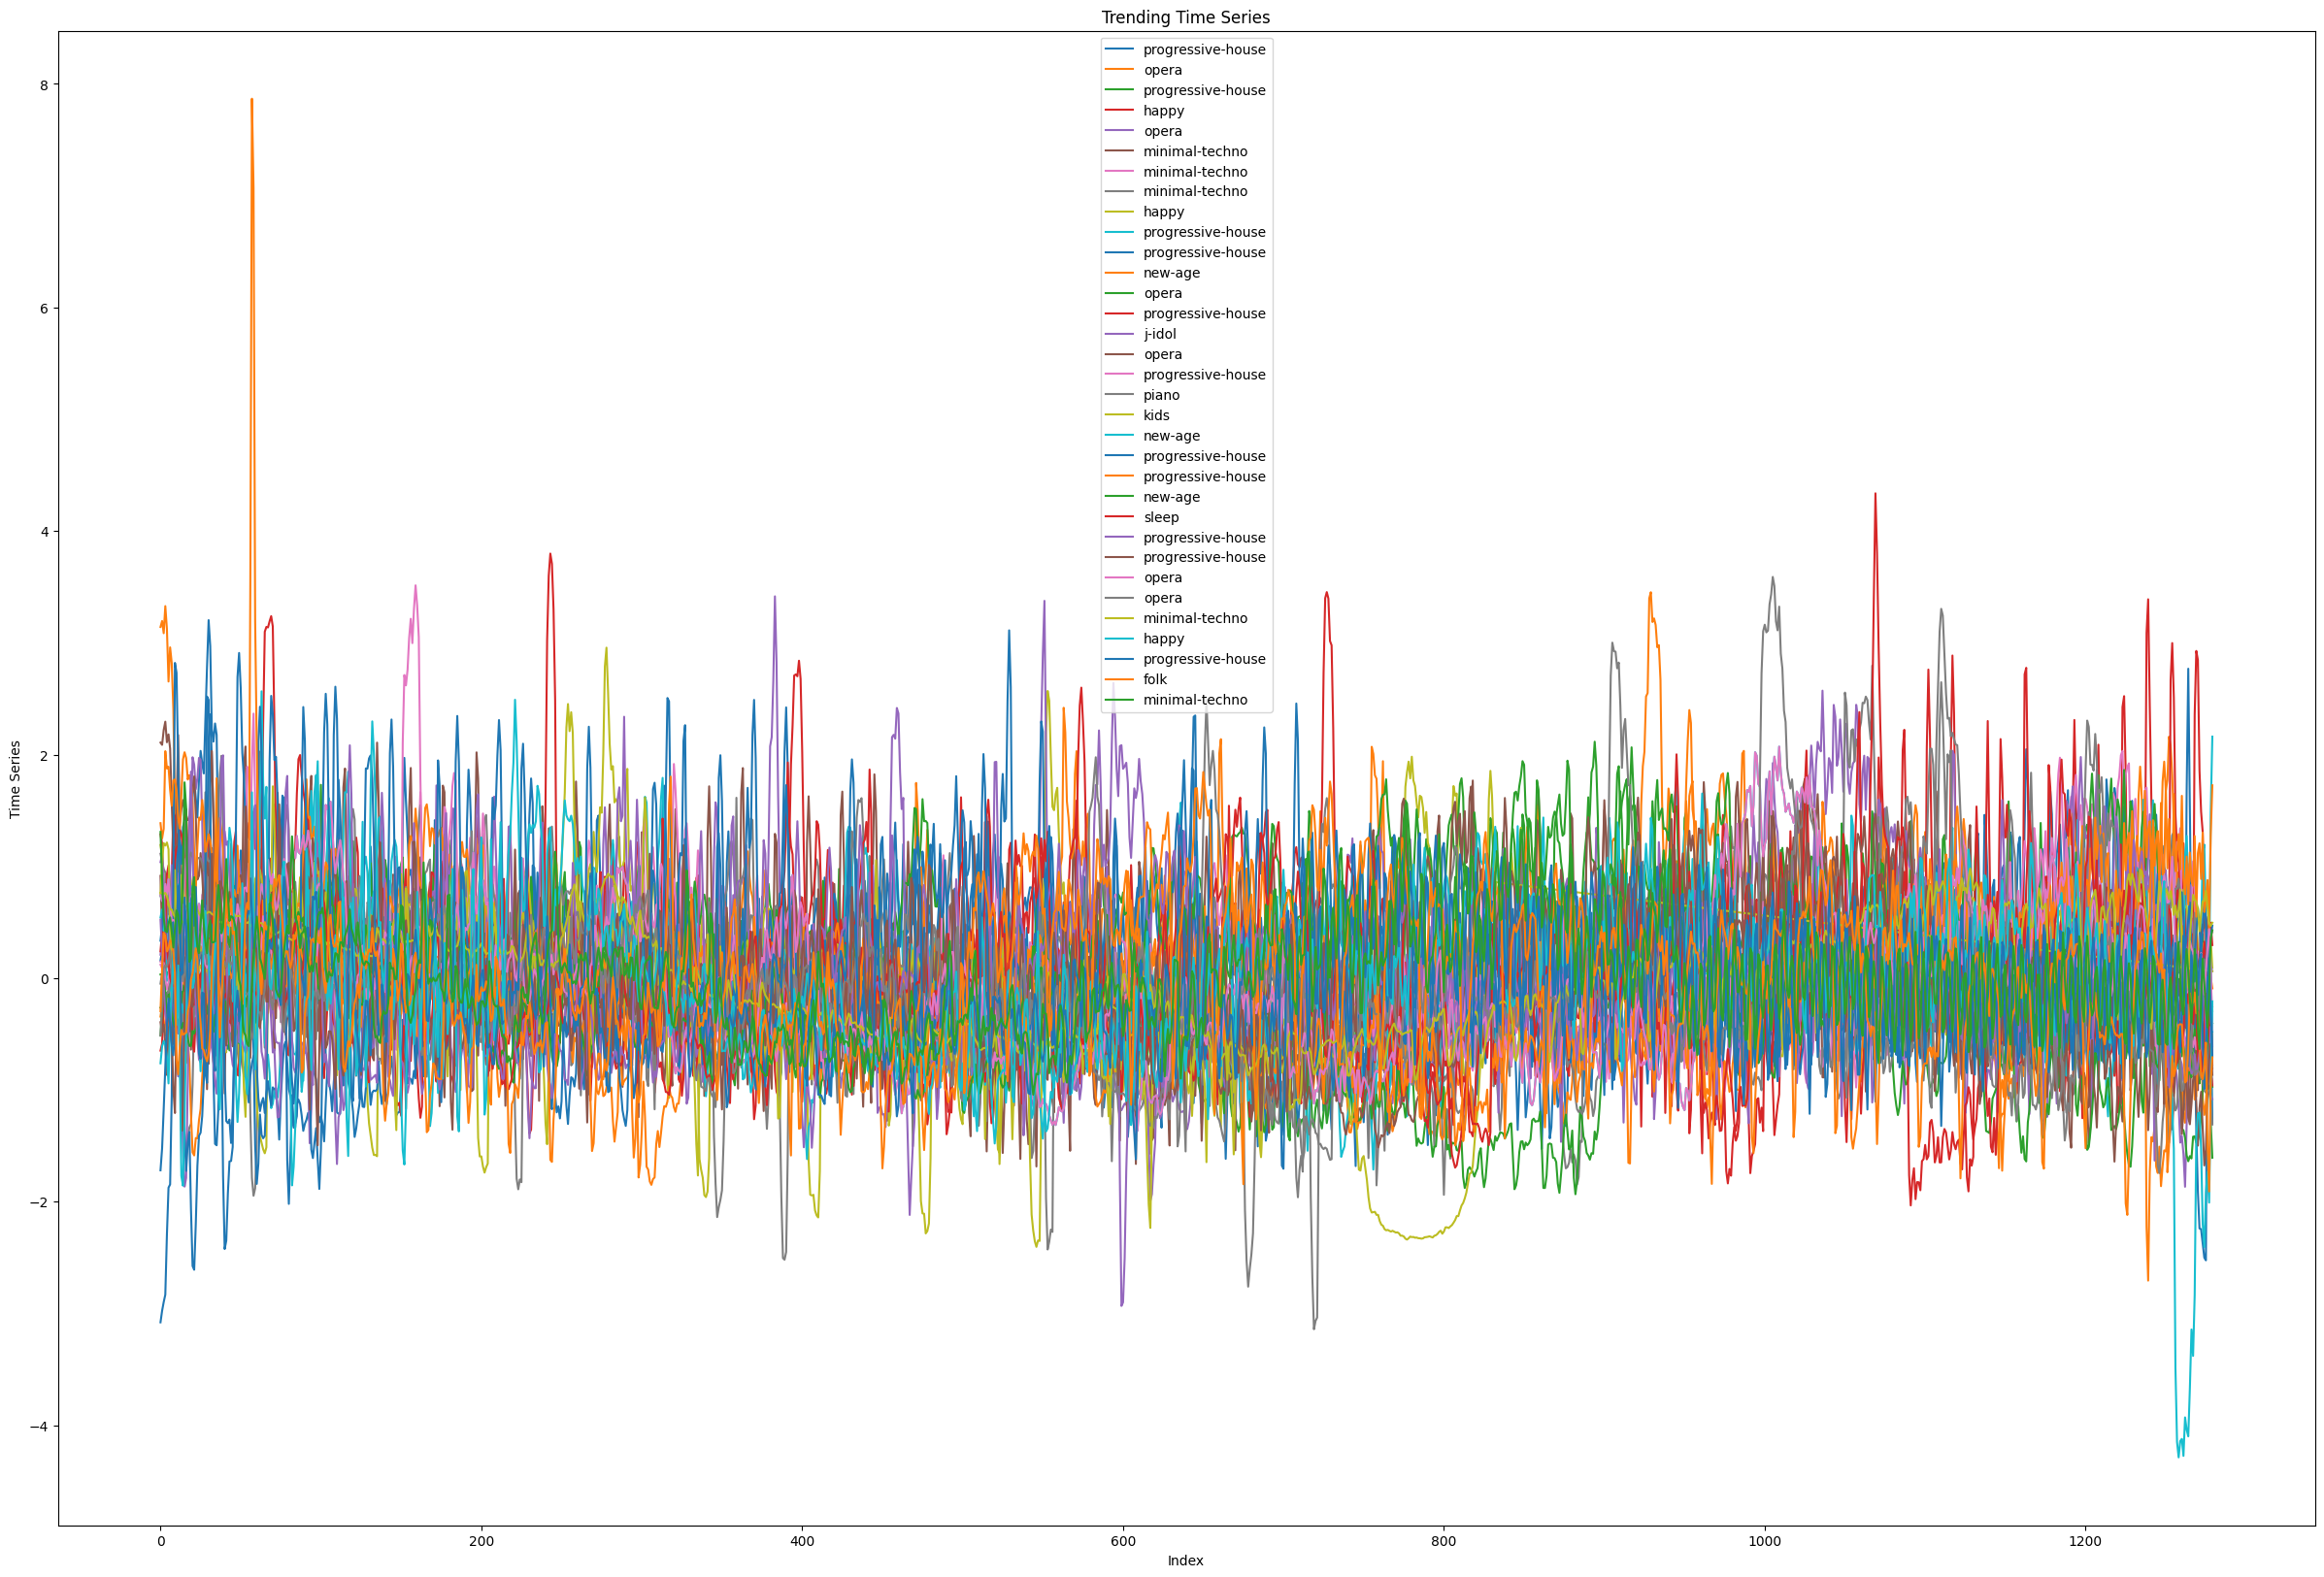

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))
for index in trending_series_indices:
    plt.plot(X[index][0])
    
plt.xlabel('Index')
plt.ylabel('Time Series')
plt.title('Trending Time Series')
plt.legend(y[trending_series_indices])
plt.show()

# Save cleaned time series in new folder

In [ ]:
import numpy as np
import os

# Directory di output per i file npy
output_directory = "./dataset/cleaned_time_series"

# Itera attraverso ciascuna serie temporale e salvala in un file npy
for i, serie in enumerate(X):
    # Trasponi la serie temporale prima di salvarla
    serie_trasposta = serie.reshape(-1, 1)  # Rappresenta la serie temporale come una singola colonna
    filename = f"{ids[i]}_{y[i]}.npy"
    np.save(os.path.join(output_directory, filename), serie_trasposta)